## 1. 사용할 패키지 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. 데이터 불러오기

In [4]:
trade = pd.read_csv('2019-05-trade.csv')
orderbook = pd.read_csv('2019-05-17-BTC-orderbook.csv')

## 3. 문제 풀이

### (1) Task 1

#### - 누적 수량 계산하기

In [5]:
## side = 1 인 경우 quantity에 -1을 곱해주자.
trade['real_quantity'] = trade['quantity']
trade['real_quantity'][trade['side'] == 1] = -trade['real_quantity'][trade['side'] == 1]

/tmp/ipykernel_32351/905381241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade['real_quantity'][trade['side'] == 1] = -trade['real_quantity'][trade['side'] == 1]


In [6]:
## cumsum 함수를 통해 누적 quantity 계산
trade['cumsum_quantity'] = np.cumsum(trade['real_quantity'])

In [7]:
## 데이터의 마지막 행의 누적 quantity는 0에 매우 가까운 값이므로 이 시점의 amount의 누적합을 계산하면 된다.
trade['cumsum_amount'] = np.cumsum(trade['amount'])
list(trade['cumsum_amount'])[-1]
  

1728400

약 1728400원의 이익을 본 것을 계산할 수 있다.

### (2) Task 2

#### - Time 변수에서 '일' 단위 추출

In [8]:
trade['timestamp'] = pd.to_datetime(trade['timestamp'])

def extract_day(timestamp):
    return timestamp.day

trade['day'] = trade['timestamp'].map(extract_day)
trade.head()

,timestamp,quantity,price,fee,amount,side,real_quantity,cumsum_quantity,cumsum_amount,day
0,2019-05-16 13:32:00,0.022435,9568000,107.32,-214764,0,0.022435,0.022435,-214764,16
1,2019-05-16 13:32:00,0.004065,9568000,19.44,-38916,0,0.004065,0.026500,-253680,16
2,2019-05-16 13:32:00,0.007700,9568000,36.83,-73711,0,0.007700,0.034200,-327391,16
3,2019-05-16 13:32:00,0.800815,9568000,3831.09,-7666025,0,0.800815,0.835015,-7993416,16
4,2019-05-16 13:32:00,0.052347,9568000,250.42,-501105,0,0.052347,0.887361,-8494521,16


#### - day와 side변수를 기준으로 Group화

In [9]:
trade_grouped = trade.groupby(['day', 'side'])['quantity'].sum().reset_index(drop = False)
trade_grouped.head()

,day,side,quantity
0,16,0,156.684744
1,16,1,153.684671
2,17,0,296.048407
3,17,1,296.896681
4,18,0,197.969102


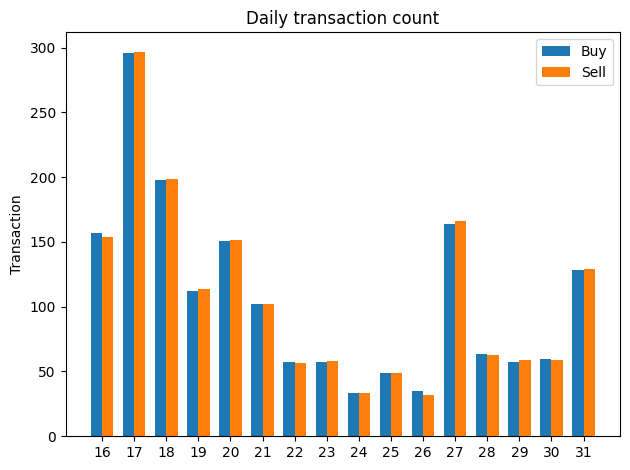

In [10]:
labels = range(16, 32)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, trade_grouped['quantity'][trade_grouped['side'] == 0], width, label='Buy')
rects2 = ax.bar(x + width/2, trade_grouped['quantity'][trade_grouped['side'] == 1], width, label='Sell')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Transaction')
ax.set_title('Daily transaction count')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### (3) Task 3

#### - Orderbook의 Timestamp를 초 단위로 반올림 하기

In [11]:
orderbook['timestamp'] = pd.to_datetime(orderbook['timestamp'])

def round_timestamp(timestamp):
    return timestamp.replace(microsecond=0) 

orderbook['timestamp'] = orderbook['timestamp'].map(round_timestamp)
orderbook['timestamp']

0         2019-05-17 00:00:00
1         2019-05-17 00:00:00
2         2019-05-17 00:00:00
3         2019-05-17 00:00:00
4         2019-05-17 00:00:00
                  ...        
2591515   2019-05-17 23:59:59
2591516   2019-05-17 23:59:59
2591517   2019-05-17 23:59:59
2591518   2019-05-17 23:59:59
2591519   2019-05-17 23:59:59
Name: timestamp, Length: 2591520, dtype: datetime64[ns]

#### - timestamp와 type	변수를 기준으로 Group화 (Max Price, Average Price, Average quantity)

In [12]:
max_price = orderbook.groupby(['timestamp', 'type'])['price'].max().reset_index(drop = False)
average_price = orderbook.groupby(['timestamp', 'type'])['price'].mean().reset_index(drop = False)
average_quantity = orderbook.groupby(['timestamp', 'type'])['quantity'].mean().reset_index(drop = False)

#### - ask와 bid로 분할

In [13]:
max_price_ask = max_price.loc[max_price['type'] == 1, :].reset_index(drop = True)
max_price_bid = max_price.loc[max_price['type'] == 0, :].reset_index(drop = True)

average_price_ask = average_price.loc[average_price['type'] == 1, :].reset_index(drop = True)
average_price_bid = average_price.loc[average_price['type'] == 0, :].reset_index(drop = True)

average_quantity_ask = average_quantity.loc[average_quantity['type'] == 1, :].reset_index(drop = True)
average_quantity_bid = average_quantity.loc[average_quantity['type'] == 0, :].reset_index(drop = True)

#### - 위 정보를 하나의 데이터프레임으로 생성

In [14]:
final = pd.DataFrame({'timestamp': max_price_ask['timestamp'], 'max_price_ask': max_price_ask['price'], 'max_price_bid': max_price_bid['price'], 'average_price_ask': average_price_ask['price'], 'average_price_bid': average_price_bid['price'], 'average_quantity_ask': average_quantity_ask['quantity'], 'average_quantity_bid': average_quantity_bid['quantity']})
final.head()

,timestamp,max_price_ask,max_price_bid,average_price_ask,average_price_bid,average_quantity_ask,average_quantity_bid
0,2019-05-17 00:00:00,9491000.0,9449000.0,9.471333e+06,9438800.0,2.248895,3.144560
1,2019-05-17 00:00:01,9491000.0,9449000.0,9.471467e+06,9438800.0,2.248229,3.142442
2,2019-05-17 00:00:02,9499000.0,9449000.0,9.474933e+06,9438800.0,2.287988,3.109909
3,2019-05-17 00:00:03,9497000.0,9449000.0,9.473867e+06,9438800.0,2.234896,3.142442
4,2019-05-17 00:00:04,9497000.0,9449000.0,9.473867e+06,9438800.0,2.234896,3.142442


#### - MidPrice 계산

In [15]:
final['MidPrice'] = (final['max_price_ask'] + final['max_price_bid']) / 2

#### - Bfeature 계산

In [18]:
final['book_price'] = (final['average_quantity_ask'] * final['average_price_bid']) / final['average_quantity_bid']
final['Bfeature'] = final['book_price'] - final['MidPrice']

#### - Alpha 계산

In [19]:
final['Alpha'] = final['Bfeature'] * final['MidPrice']

In [20]:
final.head()

,timestamp,max_price_ask,max_price_bid,average_price_ask,average_price_bid,average_quantity_ask,average_quantity_bid,MidPrice,book_price,Bfeature,Alpha
0,2019-05-17 00:00:00,9491000.0,9449000.0,9.471333e+06,9438800.0,2.248895,3.144560,9470000.0,6.750348e+06,1.047776e+06,9.922441e+12
1,2019-05-17 00:00:01,9491000.0,9449000.0,9.471467e+06,9438800.0,2.248229,3.142442,9470000.0,6.752896e+06,1.047776e+06,9.922441e+12
2,2019-05-17 00:00:02,9499000.0,9449000.0,9.474933e+06,9438800.0,2.287988,3.109909,9474000.0,6.944211e+06,1.043776e+06,9.888736e+12
3,2019-05-17 00:00:03,9497000.0,9449000.0,9.473867e+06,9438800.0,2.234896,3.142442,9473000.0,6.712848e+06,1.044776e+06,9.897166e+12
4,2019-05-17 00:00:04,9497000.0,9449000.0,9.473867e+06,9438800.0,2.234896,3.142442,9473000.0,6.712848e+06,1.044776e+06,9.897166e+12


#### - 계산한 정보만 남기기

In [21]:
final = final.loc[:, ['timestamp', 'MidPrice', 'Bfeature', 'Alpha']]
final.head()

,timestamp,MidPrice,Bfeature,Alpha
0,2019-05-17 00:00:00,9470000.0,1.047776e+06,9.922441e+12
1,2019-05-17 00:00:01,9470000.0,1.047776e+06,9.922441e+12
2,2019-05-17 00:00:02,9474000.0,1.043776e+06,9.888736e+12
3,2019-05-17 00:00:03,9473000.0,1.044776e+06,9.897166e+12
4,2019-05-17 00:00:04,9473000.0,1.044776e+06,9.897166e+12


#### - trade 데이터프레임에 합치기

In [75]:
trade = pd.read_csv('2019-05-trade.csv')
trade['timestamp'] = pd.to_datetime(trade['timestamp'])

new_trade = pd.merge(trade, final)
new_trade.head()

,timestamp,quantity,price,fee,amount,side,MidPrice,Bfeature,Alpha
0,2019-05-17,0.057701,9449000,272.60,544941,1,9470000.0,-2.719652e+06,8.968090e+13
1,2019-05-17,0.005000,9449000,23.62,47221,1,9470000.0,-2.719652e+06,8.968090e+13
2,2019-05-17,0.127708,9449000,603.35,1206112,1,9470000.0,-2.719652e+06,8.968090e+13
3,2019-05-17,1.057672,9449000,4996.97,9988947,1,9470000.0,-2.719652e+06,8.968090e+13
4,2019-05-17,0.068212,9449000,322.26,644212,1,9470000.0,-2.719652e+06,8.968090e+13


#### - 필요한 열만 남기기

In [78]:
new_trade = new_trade.loc[:, ['timestamp', 'quantity', 'price', 'MidPrice', 'Bfeature', 'Alpha', 'side']]
new_trade.head()

,timestamp,quantity,price,MidPrice,Bfeature,Alpha,side
0,2019-05-17,0.057701,9449000,9470000.0,-2.719652e+06,8.968090e+13,1
1,2019-05-17,0.005000,9449000,9470000.0,-2.719652e+06,8.968090e+13,1
2,2019-05-17,0.127708,9449000,9470000.0,-2.719652e+06,8.968090e+13,1
3,2019-05-17,1.057672,9449000,9470000.0,-2.719652e+06,8.968090e+13,1
4,2019-05-17,0.068212,9449000,9470000.0,-2.719652e+06,8.968090e+13,1


#### - new_csv 로 저장

In [88]:
new_trade.to_csv('new_trade.csv', index = False)